In [1]:
# # Code to convert this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvert Reconstructions.ipynb --to python"
# call(command,shell=True)

In [2]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
from datetime import datetime
import webdataset as wds
import PIL
import argparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
from models import Clipper, OpenClipper, BrainNetwork, BrainDiffusionPrior, BrainDiffusionPriorOld, Voxel2StableDiffusionModel, VersatileDiffusionPriorNetwork

if utils.is_interactive():
    %load_ext autoreload
    %autoreload 2

seed=42
utils.seed_everything(seed=seed)

device: cuda


# Configurations

In [3]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # Example use
    jupyter_args = "--data_path=/../../../opt/data/private \
                    --subj=1 \
                    --model_name=test"
    
    jupyter_args = jupyter_args.split()
    print(jupyter_args)

['--data_path=/../../../opt/data/private', '--subj=1', '--model_name=test']


In [4]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="test",
    help="name of trained model",
)
parser.add_argument(
    "--autoencoder_name", type=str, default="autoencoder",
    help="name of trained autoencoder model",
)
parser.add_argument(
    "--data_path", type=str, default="/../../../opt/data/private",
    help="Path to where NSD data is stored (see README)",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,5,7],
)
parser.add_argument(
    "--img2img_strength",type=float, default=0.85,
    help="How much img2img (1=no img2img; 0=outputting the low-level image itself)",
)
parser.add_argument(
    "--recons_per_sample", type=int, default=1,
    help="How many recons to output, to then automatically pick the best one (MindEye uses 16)",
)
parser.add_argument(
    "--vd_cache_dir", type=str, default='/../../../opt/data/private/cache/versatile-diffusion',
    help="Where is cached Versatile Diffusion model; if not cached will download to this path",
)
parser.add_argument(
    "--lcm_cache_dir", type=str, default='/../../../opt/data/private/cache/LCM_Dreamshaper_v7',
    help="Where is cached Latent Consistency Model; if not cached will download to this path",
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
if autoencoder_name=="None":
    autoencoder_name = None

In [5]:
if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386
print("subj",subj,"num_voxels",num_voxels)

subj 1 num_voxels 15724


idx 0
voxel.shape torch.Size([1, 3, 15724])
img_input.shape torch.Size([1, 3, 256, 256])


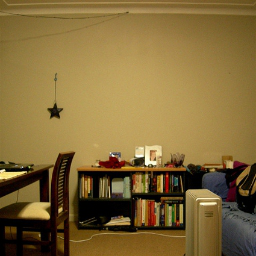

In [6]:
val_url = f"{data_path}/webdataset_avg_split/val/val_subj0{subj}_0.tar" 
meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
num_train = 8559
num_val = 300
batch_size = val_batch_size = 1
voxels_key = 'nsdgeneral.npy' # 1d inputs

val_data = wds.WebDataset(val_url, resampled=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(val_batch_size, partial=False)

val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# check that your data loader is working
for val_i, (voxel, img_input, coco) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    img = img_input[0].detach()
    img = transforms.ToPILImage()(img).show()
    break

## Load autoencoder

In [7]:
from models import Voxel2StableDiffusionModel

outdir = f'/../../../opt/data/private/train_logs/models/{autoencoder_name}'
ckpt_path = os.path.join(outdir, f'last.pth')

if os.path.exists(ckpt_path):
    #checkpoint = torch.load(ckpt_path, map_location='cpu')
    checkpoint = torch.load(ckpt_path, map_location=device)
    state_dict = checkpoint['model_state_dict']

    voxel2sd = Voxel2StableDiffusionModel(in_dim=num_voxels)

    voxel2sd.load_state_dict(state_dict,strict=False)
    voxel2sd.eval()
    voxel2sd.to(device)
    print("Loaded low-level model!")
else:
    print("No valid path for low-level model specified; not using img2img!") 
    img2img_strength = 0.85

Loaded low-level model!


# Load VD pipe

In [8]:
print('Creating versatile diffusion reconstruction pipeline...')
from diffusers import AutoPipelineForImage2Image,LCMScheduler


lcm_pipe=AutoPipelineForImage2Image.from_pretrained(lcm_cache_dir).to(device)     


lcm_pipe.unet.eval()
lcm_pipe.vae.eval()
lcm_pipe.unet.requires_grad_(False)
lcm_pipe.vae.requires_grad_(False)
num_inference_steps = 8

lcm_pipe.scheduler = LCMScheduler.from_config(lcm_pipe.scheduler.config)

# load LCM-LoRA
lcm_pipe.load_lora_weights("latent-consistency/lcm-lora-sdv1-5")


unet = lcm_pipe.unet
vae = lcm_pipe.vae
noise_scheduler = lcm_pipe.scheduler 

Creating versatile diffusion reconstruction pipeline...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Load Versatile Diffusion model

ViT-L/14 cuda
ckpt_path /../../../opt/data/private/path/last.pth
EPOCH:  199


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


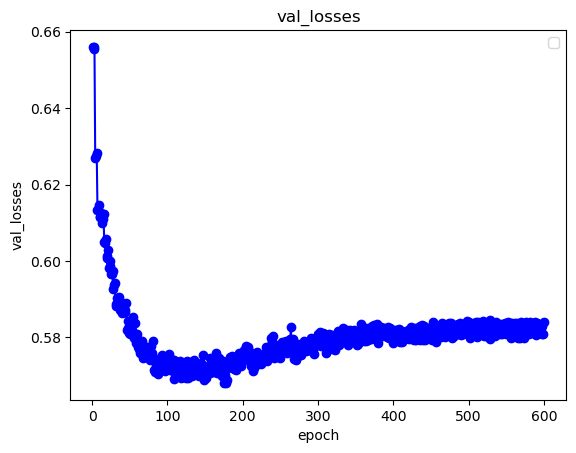

In [9]:
import matplotlib.pyplot as plt
img_variations = False

out_dim = 77 * 768
clip_extractor = Clipper("ViT-L/14", hidden_state=True, norm_embs=True, device=device)
clip_extractor.to(device)
voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
voxel2clip.requires_grad_(False)

outdir = f'=/train_logs/{model_name}'
ckpt_path = os.path.join(outdir, f'last.pth')
ckpt_path = os.path.join('/../../../opt/data/private/path/last.pth')
print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print("EPOCH: ",checkpoint['epoch'])
voxel2clip.load_state_dict(state_dict,strict=False)
voxel2clip.eval().to(device)

x_values = list(range(1, 601))
y_values = checkpoint['val_losses']  # 请替换成您的实际数据

# 使用plt.plot()绘制折线图
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')

# 添加标题和标签
plt.title('val_losses')
plt.xlabel('epoch')
plt.ylabel('val_losses')

# 添加图例
plt.legend()

# 显示图形
plt.show()
# diffusion_priors = [diffusion_prior]
pass


# Reconstruct one-at-a-time

2024-04-12 17:31:45


  0%|          | 0/300 [00:00<?, ?it/s]

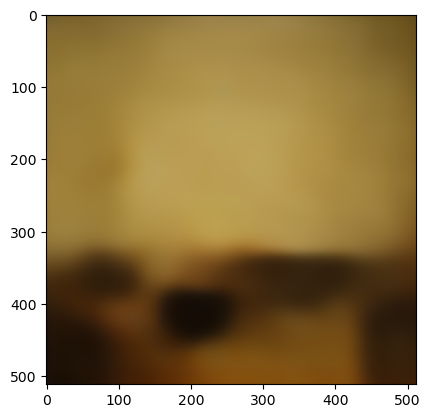

/root/fMRI-reconstruction-NSD/src/utils.py:547: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  shape = (batch_size, unet.in_channels, height // vae_scale_factor, width // vae_scale_factor)
/root/anaconda3/envs/mindeye/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the infer

2024-04-12 17:41:44
recon_path: test_recons_img2img0.85_1samples


In [12]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

retrieve = False
plotting = False
saving = True
verbose = False
imsize = 512

if img_variations:
    guidance_scale = 7.5
else:
    guidance_scale = 3.5
    
ind_include = np.arange(num_val)
all_brain_recons = None
    
only_lowlevel = False
if img2img_strength == 1:
    img2img = False
elif img2img_strength == 0:
    img2img = True
    only_lowlevel = True
else:
    img2img = True
    
for val_i, (voxel, img, coco) in enumerate(tqdm(val_dl,total=len(ind_include))):
    if val_i<np.min(ind_include):
        continue
    voxel = torch.mean(voxel,axis=1).to(device)
    # voxel = voxel[:,0].to(device)
    
    with torch.no_grad():
        if img2img:
            ae_preds = voxel2sd(voxel.float())
            #blurry_recons = vd_pipe.vae.decode(ae_preds.to(device).half()/0.18215).sample / 2 + 0.5

            lcm_pipe.vae = lcm_pipe.vae.to(device)
            blurry_recons = lcm_pipe.vae.decode(ae_preds.to(device).half().to(torch.float32)/0.18215).sample / 2 + 0.5

            if val_i==0:
                plt.imshow(utils.torch_to_Image(blurry_recons))
                plt.show()
        else:
            blurry_recons = None

        if only_lowlevel:
            brain_recons = blurry_recons
        else:

            grid, brain_recons, laion_best_picks, recon_img = utils.reconstruction(
                img, voxel,
                clip_extractor, unet, vae, noise_scheduler,
                voxel2clip_cls = None, #diffusion_prior_cls.voxel2clip,
                voxel2clip = voxel2clip, #without diffusion_prior, use voxel2cip directly, also change code in utils
                # diffusion_priors = None,
                text_token = None,
                img_lowlevel = blurry_recons,
                num_inference_steps = num_inference_steps,
                n_samples_save = batch_size,
                recons_per_sample = recons_per_sample,
                guidance_scale = guidance_scale,
                img2img_strength = img2img_strength, # 0=fully rely on img_lowlevel, 1=not doing img2img
                timesteps_prior = 100,
                seed = seed,
                retrieve = retrieve,
                plotting = plotting,
                img_variations = img_variations,
                verbose = verbose,
            )

            if plotting:
                plt.show()
                # grid.savefig(f'evals/{model_name}_{val_i}.png')

            # brain_recons = brain_recons[:,laion_best_picks.astype(np.int8)]

        if all_brain_recons is None:
            all_brain_recons = brain_recons
            all_images = img
        else:
            all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
            all_images = torch.vstack((all_images,img))

    if val_i>=np.max(ind_include):
        break

all_brain_recons = all_brain_recons.view(-1,3,imsize,imsize)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

if saving:
    torch.save(all_images,f'all_images.pt')
    torch.save(all_brain_recons,f'{model_name}_recons_img2img{img2img_strength}_{recons_per_sample}samples.pt')
print(f'recon_path: {model_name}_recons_img2img{img2img_strength}_{recons_per_sample}samples')

if not utils.is_interactive():
    sys.exit(0)